In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from time import time
import json
import sys

from thorr.utils import read_config

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

from sklearn.model_selection import KFold, ShuffleSplit, RepeatedKFold, train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.inspection import permutation_importance

from joblib import dump, load

from permetrics.regression import RegressionMetric
from scipy import stats

In [2]:
config_path = Path('/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/03-HAB/.env/hab_config.ini')
config_dict = read_config(config_path)
project_dir = Path(config_dict["project"]["project_dir"])

seed = 1955

test_size = 0.2
n_splits = 5
n_repeats = 10

In [3]:
hls_insitu = pd.read_csv(project_dir / 'data/hls_insitu/hls_insitu.csv', low_memory=False)
hls_insitu['Date'] = pd.to_datetime(hls_insitu['Date'])
hls_insitu['log_chl_a'] = np.log10(hls_insitu['chl_a'])

In [4]:
chl_wqp_usgs = pd.read_csv('chl_wqp_usgs.csv')

chl_wqp_usgs['Date'] = pd.to_datetime(chl_wqp_usgs['Date'])
chl_wqp_usgs['log_chl_a'] = np.log10(chl_wqp_usgs['chl_a'])

In [5]:
# find the mean, median and mode of chl_a
mean_chl_a = hls_insitu['chl_a'].mean()
median_chl_a = hls_insitu['chl_a'].median()
mode_chl_a = hls_insitu['chl_a'].mode()[0]

# find the mean, median and mode of log_chl_a
mean_log_chl_a = hls_insitu['log_chl_a'].mean()
median_log_chl_a = hls_insitu['log_chl_a'].median()
mode_log_chl_a = hls_insitu['log_chl_a'].mode()[0]

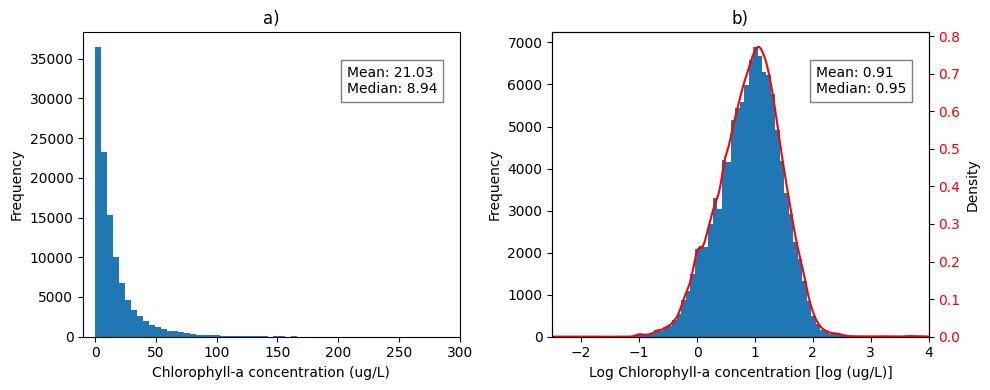

In [6]:
# plot plot kde and histogram of chl_a log scales
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(10,4))
# ax2 = ax1.twinx()
ax4 = ax3.twinx()

hls_insitu['chl_a'].plot.hist(bins=2000, ax=ax1)
# hls_insitu['chl_a'].plot.kde(ax=ax2, color='red')
hls_insitu['log_chl_a'].plot.hist(bins=75, ax=ax3)
hls_insitu['log_chl_a'].plot.kde(ax=ax4, color='red')

# make both twin axes start from 0
ax1.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)
ax3.set_ylim(bottom=0)
ax4.set_ylim(bottom=0)
# make x axis log scale
ax1.set_xlabel('Chlorophyll-a concentration (ug/L)')
# set x axis limits
ax1.set_xlim([-10, 300])
ax3.set_xlabel('Log Chlorophyll-a concentration [log (ug/L)]')
# set x axis limits
ax3.set_xlim([-2.5, 4])

ax4.tick_params(axis='y', labelcolor='red')
ax1.set_title('a)')
ax3.set_title('b)')

# annotate mean, median and mode on both plots. add text instead of lines
ax1.text(0.7, 0.8, f'Mean: {mean_chl_a:.2f}\nMedian: {median_chl_a:.2f}', transform=ax1.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
ax3.text(0.7, 0.8, f'Mean: {mean_log_chl_a:.2f}\nMedian: {median_log_chl_a:.2f}', transform=ax3.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()
fig.savefig('chl_a_distribution.png', dpi=300)


In [7]:
# find the mean, median and mode of chl_a
mean_chl_a = chl_wqp_usgs['chl_a'].mean()
median_chl_a = chl_wqp_usgs['chl_a'].median()
mode_chl_a = chl_wqp_usgs['chl_a'].mode()[0]

# find the mean, median and mode of log_chl_a
mean_log_chl_a = chl_wqp_usgs['log_chl_a'].mean()
median_log_chl_a = hls_insitu['log_chl_a'].median()
mode_log_chl_a = hls_insitu['log_chl_a'].mode()[0]

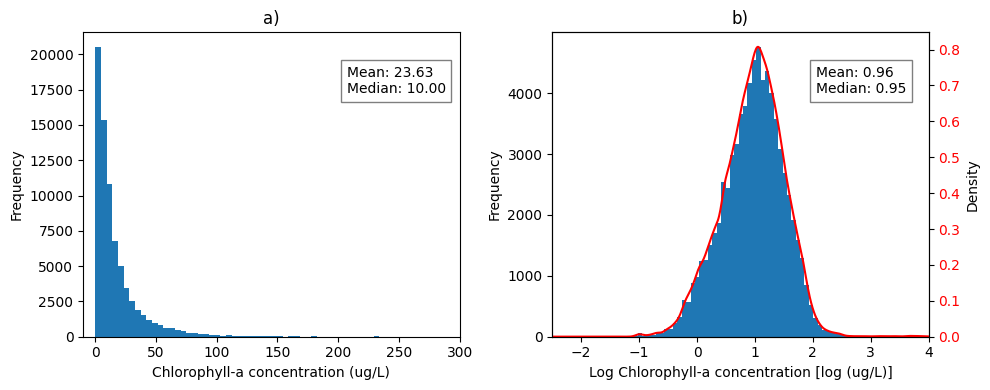

In [8]:
# plot plot kde and histogram of chl_a log scales
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(10,4))
# ax2 = ax1.twinx()
ax4 = ax3.twinx()

chl_wqp_usgs['chl_a'].plot.hist(bins=2000, ax=ax1)
# chl_wqp_usgs['chl_a'].plot.kde(ax=ax2, color='red')
chl_wqp_usgs['log_chl_a'].plot.hist(bins=75, ax=ax3)
chl_wqp_usgs['log_chl_a'].plot.kde(ax=ax4, color='red')

# make both twin axes start from 0
ax1.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)
ax3.set_ylim(bottom=0)
ax4.set_ylim(bottom=0)
# make x axis log scale
ax1.set_xlabel('Chlorophyll-a concentration (ug/L)')
# set x axis limits
ax1.set_xlim([-10, 300])
ax3.set_xlabel('Log Chlorophyll-a concentration [log (ug/L)]')
# set x axis limits
ax3.set_xlim([-2.5, 4])

ax4.tick_params(axis='y', labelcolor='red')
ax1.set_title('a)')
ax3.set_title('b)')

# annotate mean, median and mode on both plots. add text instead of lines
ax1.text(0.7, 0.8, f'Mean: {mean_chl_a:.2f}\nMedian: {median_chl_a:.2f}', transform=ax1.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
ax3.text(0.7, 0.8, f'Mean: {mean_log_chl_a:.2f}\nMedian: {median_log_chl_a:.2f}', transform=ax3.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()
fig.savefig('chl_a_distribution.png', dpi=300)


In [9]:
# count number of chl_a values (exclude NaN)
n_chl_a = chl_wqp_usgs['chl_a'].count()
n_log_chl_a = chl_wqp_usgs['log_chl_a'].count()

print(f'Number of chl_a samples: {n_chl_a}')
print(f'Number of log_chl_a samples: {n_log_chl_a}')

# chl percentiles
_12ug = stats.percentileofscore(chl_wqp_usgs['chl_a'], 12)
_24ug = stats.percentileofscore(chl_wqp_usgs['chl_a'], 24)
_log_12ug = stats.percentileofscore(chl_wqp_usgs['log_chl_a'], np.log10(12))
_log_24ug = stats.percentileofscore(chl_wqp_usgs['log_chl_a'], np.log10(24))

print(f'12 ug/L is at the {_12ug:.2f} percentile')
print(f'24 ug/L is at the {_24ug:.2f} percentile')
print(f'Log 12 ug/L is at the {_log_12ug:.2f} percentile')
print(f'Log 24 ug/L is at the {_log_24ug:.2f} percentile')


Number of chl_a samples: 75217
Number of log_chl_a samples: 75217
12 ug/L is at the 56.60 percentile
24 ug/L is at the 78.37 percentile
Log 12 ug/L is at the 56.60 percentile
Log 24 ug/L is at the 78.37 percentile


In [10]:
np.log10(12)

np.float64(1.0791812460476249)

In [11]:
# calculate standard deviation and variance of chl_a and log_chl_a
std_chl_a = chl_wqp_usgs['chl_a'].std()
var_chl_a = chl_wqp_usgs['chl_a'].var()
std_log_chl_a = chl_wqp_usgs['log_chl_a'].std()
var_log_chl_a = chl_wqp_usgs['log_chl_a'].var()
print(f'Standard Deviation of chl_a: {std_chl_a:.2f}')
print(f'Variance of chl_a: {var_chl_a:.2f}')
print(f'Standard Deviation of log_chl_a: {std_log_chl_a:.2f}')
print(f'Variance of log_chl_a: {var_log_chl_a:.2f}')

Standard Deviation of chl_a: 181.95
Variance of chl_a: 33105.20
Standard Deviation of log_chl_a: 0.54
Variance of log_chl_a: 0.29


In [12]:
# count number of chl_a values (exclude NaN)
n_chl_a = chl_wqp_usgs['chl_a'].count()
n_log_chl_a = chl_wqp_usgs['log_chl_a'].count()

print(f'Number of chl_a samples: {n_chl_a}')
print(f'Number of log_chl_a samples: {n_log_chl_a}')

Number of chl_a samples: 75217
Number of log_chl_a samples: 75217


In [13]:
# Normality test on log transformed chl_a
shapiro_test = stats.shapiro(hls_insitu['log_chl_a'].dropna())
kstest = stats.kstest(hls_insitu['log_chl_a'].dropna(), 'norm', args=(hls_insitu['log_chl_a'].mean(), hls_insitu['log_chl_a'].std()))
print(f"Shapiro-Wilk test statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}")
print(f"Kolmogorov-Smirnov test statistic: {kstest.statistic}, p-value: {kstest.pvalue}")

Shapiro-Wilk test statistic: 0.9919226671699959, p-value: 8.066366269943831e-56
Kolmogorov-Smirnov test statistic: 0.0313435754011952, p-value: 6.960288181996262e-97


/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/01-THORR/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 113004.
  res = hypotest_fun_out(*samples, **kwds)


The log of chlorophyll-a measurements follow a normal distribution. However, for a random forest model, it will be ideal to obtain a uniform distribution across all the range of target values. To do this, I will apply an oversampling technique to create a relatively uniform distribution of all the values.

Can I check the frequency of high concentrations in the various regions?